In [1]:
from min30_LSTM_conv_znBinomial import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential
import os

Num GPUs: 1


Using TensorFlow backend.


In [2]:
source_model,checkpoint,modelpath,train,test = getModel()
#source_model,modelpath,train,test = getModel(True)
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
source_model.load_weights(laststate["modelpath"])
test.setWiggle_off()
#loss = source_model.evaluate(x=test, verbose=1)
#print("Restored model, loss: {:5.5f}".format(loss))

predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 5)    230         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 5)    30          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 5)    230         input_1[0][0]                    
______________________________________________________________________________________________

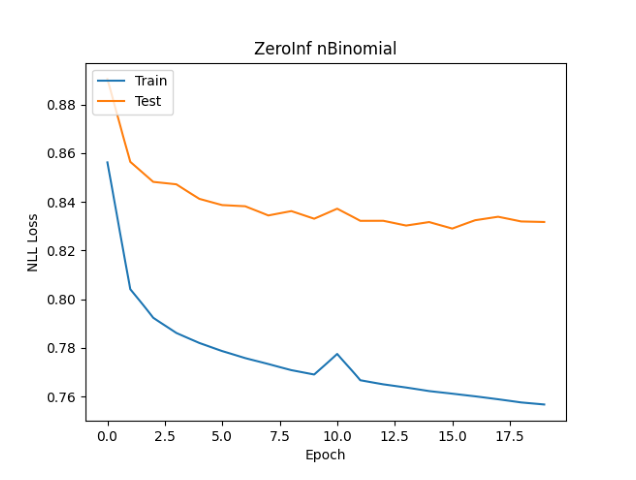

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()
y_transform = [cutOut([16,80,16,80])]


In [4]:
def getFreshSet(batch_size=1):
    y_transform = [cutOut([16,80,16,80])]
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         y_transform=y_transform)
    return train,test

In [11]:
output_dist = tfp.layers.DistributionLambda(
        name="DistributionLayer",
        make_distribution_fn=lambda t: tfp.distributions.Independent(
        tfd.Mixture(
            cat=tfd.Categorical(tf.stack([1-tf.math.sigmoid(t[...,:1]), tf.math.sigmoid(t[...,:1])],axis=-1)),
            components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
            tfp.distributions.NegativeBinomial(
            total_count=tf.math.softplus(t[..., 1:2]), 
            logits=tf.math.sigmoid(t[..., 2:]) ),])
        ,name="ZeroInflated_Binomial",reinterpreted_batch_ndims=0 ))


pred = None
label = None
pred = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)
test.on_epoch_end()
test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            pred = output_dist(pred)
            mean.append(pred.mean())
            stdev.append(pred.sample())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            atm.append(x[i,:,:,-1:])
            if len(label) == 20:
                break
    break
    if len(label) == 20:
                break

In [1]:
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)

for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,3].imshow(y_transform[0](atm[batch][:,:,-1]),cmap="gray")
plt.show()

NameError: name 'plt' is not defined

In [7]:
train,test =  getFreshSet(batch_size=100)
baseline = multiProc_eval(model,test,getFreshSet,x_transform=y_transform)

Worker  0 finishedd   2200 images
Worker  1 finishedd   2200 images
Worker  2 finishedd   2200 images
Worker  3 finishedd   2200 images
Worker  4 finishedd   2200 images
Worker  5 finishedd   2200 images
Worker  6 finishedd   2200 images
Worker  7 finishedd   2200 images
Worker  8 finishedd   2200 images
Worker  9 finishedd   2200 images
Worker 10 finishedd   2200 images
Worker 11 finishedd   2200 images
Worker 12 finishedd   2200 images
Worker 13 finishedd   2200 images
Worker 14 finishedd   2200 images
Worker 15 finishedd   2200 images
Worker 16 finishedd   2200 images
Worker 17 finishedd   2200 images
Worker 18 finishedd   2200 images
Worker 19 finishedd   2200 images
Worker 20 finishedd   2200 images
Worker 21 finishedd   2200 images
Worker 22 finishedd   2200 images
Worker 23 finishedd   2200 images
Worker 24 finishedd   2200 images
Worker 25 finishedd   2200 images
Worker 26 finishedd   2200 images
Worker 27 finishedd   2200 images
Worker 28 finishedd   2200 images
Worker 29 fini

<Figure size 2000x3000 with 0 Axes>

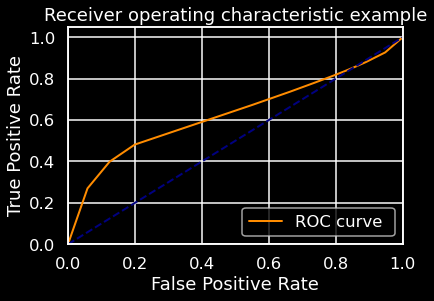

In [8]:
baseline_dict = baseline.copy()
plotAUC(baseline_dict)